프로젝트 : BERT Pretrained model의 활용
==== 
     
KorQuAD(The Korean Question Answering Dataset, 한국어 질의응답 데이터셋)을 통해 자연어처리 분야의 기계독해(Machine Reading Comprehension, MRC) 태스크를 다루어 봅니다. 
KorQuAD 태스크를 BERT(Bidirectional Encoder Representations from Transformers) 모델을 활용하여 학습해 봅시다.
     
1. BERT model 사용하기    
    - 1.1 BERT의 model 구조
    - 1.2 model finetune 하기
    - 1.3 Inference 수행하기    
    
    
2. BERT Pretrained model 사용하기
    - 2.1 pretrained model 로딩하기
    - 2.2 pretrained model finetune 하기
    - 2.3 Inference 수행하기     
    
    
3. 학습 경과 시각화 비교분석
   
-21.11.30-

In [1]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# KorQuAD 데이터셋 

KorQuAD (The Korean Question Answering Dataset, 한국어 질의응답 데이터셋)

In [2]:
# 디렉토리 지정
data_dir = os.getenv('HOME')+'/aiffel/Exploration/E17/data'
model_dir = os.getenv('HOME')+'/aiffel/Exploration/E17/models'

In [3]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

True

In [4]:
# 전처리 한 데이터 로드 
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

- KorQuAD 데이터셋 전처리 
    
    1) 띄어쓰기 단위 정보관리    
    2) Tokenize by Vocab : SentencePiece 모델을 이용한 Subword 기반의 텍스트 전처리     
    3) Improve Span    
    4) 데이터셋 분리 : train 데이터셋, dev 데이터셋을 분리     
        
    다음과 같은 전처리를 거친 train, dev 데이터 셋을 사용합니다. 

In [7]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_seq_length': 384, 'max_query_length': 64}

In [8]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            # qa_id, title, question, context, answer, token_start, token_end
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')
    
    # question토큰+context토큰 , question(0)+context(1) / answer label start, end
    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [9]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

# data 확인
train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

# 1. BERT model 사용하기

BERT(Bidirectional Encoder Representations from Transformers) 

## 1.1 BERT의 model 구조 

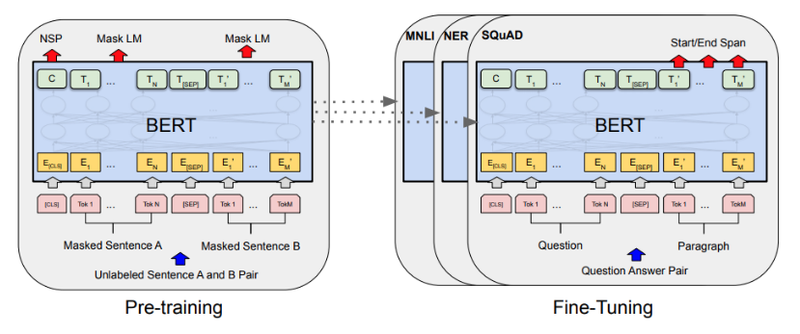    
    
- Mask LM
- Next Sentence Prediction
- Token Embedding
- Segment Embedding
- Position Embedding

In [10]:
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))
    # gelu(x) = 0.5x * ( 1 + tanh( (2/pi)^1/2*(x + 0.44715x^3)) )


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [11]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [12]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [13]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # Attention(Q, K, V) = softmax( QKT / √dk )V
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [14]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [15]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [16]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [17]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

## 1.2 model finetune 하기

BERT 레이어에 Fully Connected layer를 붙어 KorQuAD용으로 finetune하기 위한 모델 클래스입니다.

In [18]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [19]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 512,
 'n_head': 8,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

- Config을 통해 실제로 우리가 사용할 모델 사이즈를 조정    
    Our Tiny Bert(29M parameters) : 6-layer, 512-hidden, 8-heads

In [20]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [21]:
model = BERT4KorQuAD(config)

### 학습하기

In [22]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [23]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [24]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

# 학습과정 시각화
start_loss_list = []
end_loss_list = []
start_acc_list = []
end_acc_list = []

val_start_loss_list = []
val_end_loss_list = []
val_start_acc_list = []
val_end_acc_list = []

best_acc = .0
patience = 0
for epoch in range(20):
    start_loss, end_loss, start_acc, end_acc = train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    
    start_loss_list.append(start_loss)
    end_loss_list.append(end_loss)
    start_acc_list.append(start_acc)
    end_acc_list.append(end_acc)
    
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    
    val_start_loss_list.append(start_loss)
    val_end_loss_list.append(end_loss)
    val_start_acc_list.append(start_acc)
    val_end_acc_list.append(end_acc)
    
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 5.9506, 5.9506, acc: 0.0019, 0.0061
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 5.9506, 5.9506, acc: 0.0000, 0.0026


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.9506, 5.9506, acc: 0.0005, 0.0014


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 5.9506, 5.9506, acc: 0.0075, 0.0028
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 5.9506, 5.9506, acc: 0.0030, 0.0021


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 5 >> loss: 5.9506, 5.9506, acc: 0.0037, 0.0025


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 6 >> loss: 5.9506, 5.9506, acc: 0.0033, 0.0039


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 7 >> loss: 5.9506, 5.9506, acc: 0.0014, 0.0014


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 8 >> loss: 5.9506, 5.9506, acc: 0.0014, 0.0014
early stopping


## 1.3 Inference 수행하기

학습이 완료된 model을 활용하여 실제 퀴즈 풀이 결과를 확인해 봅니다.

In [25]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [26]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

5
질문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 사람의 이름은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  임종석
예측 :  년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 사람의 이름은?[SEP] 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰 

7
질문 :  정부의 헌법개정안 준비 과정에 대해서 청와대 비서실이 아니라 국무회의 중심으로 이뤄졌어야 했다고 지적한 원로 헌법학자는?
지문 :  "내각과 장관들이 소외되고 대통령비서실의 

# 2. BERT Pretrained model 사용하기

'bert_pretrain_32000.hdf5' 에 저장된 BERT Pretrained model을 사용해 봅니다. 

## 2.1 pretrained model 로딩하기

pretrained model을 로드하여 model을 생성합니다.     
model 구조는 이전 스텝과 동일합니다.

In [19]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 512,
 'n_head': 8,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

In [20]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [27]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model2 = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model2(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model2.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model2.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  29202944  
_________________________________________________________________
dense_73 (Dense)             multiple                  1026      
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


## 2.2 pretrained model finetune 하기

In [28]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

# 학습과정 시각화
start_loss_list2 = []
end_loss_list2 = []
start_acc_list2 = []
end_acc_list2 = []

val_start_loss_list2 = []
val_end_loss_list2 = []
val_start_acc_list2 = []
val_end_acc_list2 = []

best_acc = .0
patience = 0
for epoch in range(20):
    start_loss, end_loss, start_acc, end_acc = train_epoch(model2, train_dataset, loss_fn, acc_fn, optimizer)
    
    start_loss_list2.append(start_loss)
    end_loss_list2.append(end_loss)
    start_acc_list2.append(start_acc)
    end_acc_list2.append(end_acc)
    
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model2, dev_dataset, loss_fn, acc_fn)
    
    val_start_loss_list2.append(start_loss)
    val_end_loss_list2.append(end_loss)
    val_start_acc_list2.append(start_acc)
    val_end_acc_list2.append(end_acc)
    
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        #model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        #print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.7513, 2.0053, acc: 0.5421, 0.5042


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.7814, 1.9728, acc: 0.5709, 0.5269


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.8297, 2.1899, acc: 0.5692, 0.5318


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 2.0590, 2.2816, acc: 0.5541, 0.5133


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 2.0071, 2.1553, acc: 0.5449, 0.5177


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 5 >> loss: 1.9409, 2.3509, acc: 0.5441, 0.5000


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 6 >> loss: 2.3819, 2.7885, acc: 0.5616, 0.5186


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 7 >> loss: 2.4086, 2.7402, acc: 0.5462, 0.4982
early stopping


## 2.3 Inference 수행하기

finetune 학습이 완료된 model을 활용하여 실제 퀴즈 풀이 결과를 확인해 봅니다.

In [29]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model2, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

44
질문 :  노아의 방주는 몇층으로 구성되어 있었는가?
지문 :  노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가 올 것을 미리 알게 된다. 그는 길이 300 규빗, 너비 50 규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8명의 가족과, 한 쌍씩의 여러 동물을 데리고 이 방주에 탄다. 대홍수를 만나 모든 생물(물고기 제외)이 전멸하고 말았지만, 이 방주에 탔던 노아의 가족과 동물들은 살아 남았다고 한다.〈창세기〉 6장 14~16절에 보면 길이 300규빗 (약 135m), 폭 50 규빗 (약 22.5m), 높이 30 규빗 (약 13.5m)인 이 배는 지붕과 문을 달고 배 안은 3층으로 만들어져 있었다. 선체(船體)는 고페르나무(잣나무)로 되고 안쪽에는 역청(아스팔트와 비슷한 성분)을 칠하여 굳혔다고 기록하고 있다.
정답 :  3층
예측 :  3층으로 

45
질문 :  노아의 방주에 안쪽에 발라 굳힌 것은?
지문 :  노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부정한 짐승 암수 한 마리씩(혹은 두 마리씩; 사본에 따라 다름), 그리고 새 암수 일곱 마리씩을 싣고 밀어닥친 홍수를 피하였다. 모든 사람들이 타락한 생활에 빠져 있어 하나님이 홍수로 심판하려 할 때 홀로 바르게 살던 노아는 하나님의 특별한 계시로 홍수가 올 것을 미리 알게 된다. 그는 길이 300 규빗, 너비 50 규빗, 높이 30 규빗(고대의 1규빗은 팔꿈치에서 가운데 손가락끝까지의 길이로 약 45~46cm를 가리킴), 상 ·중 ·하 3층으로 된 방주를 만들어 8명의 가족

74
질문 :  가지고 있는 특성이 없어지는 것은 진화가 아니라는 창조과학회의 주장의 예시는?
지문 :  기독교 성경 내용에는 모든 종들을 방주에 태운다고 이야기하고 있으나, 어류나 수중 생물에 대해서는 언급하지 않았다. 이것을 신학적 의미로만 받아들이면 괜찮은 문제이나, 이 현상이 실제로 일어났다고 가정할 경우,이는 종 간 생존 환경의 차이에 대해서 간과하고 있다. 수중 생물이라 하더라도 종에 따라 생존할 수 있는 환경은 각각 다른 것이며, 40일 이내에 현존하는 가장 높은 산인 에베레스트 산도 잠기게 할 정도의 폭우로 인해 담수와 염수가 급작스럽게 섞일 경우, 급격한 삼투압 변화로 인해 대부분의 수생생물들이 폐사하게 되며, 결과적으로 육지 뿐 아니라 바다와 강의 모든 생태계가 파괴된다. 이후 5천년이라는 지극히 짧은 세월 동안 지구상의 동식물이 모두 페름기 대멸종 또는 K-T 대멸종에 준하는 대량절멸에 가까운 상태에서부터 시작하여 현재의 대략 870만(±120만)종에 달하는 생물다양성을 획득하려면 모든 생물들이 각 세대마다 종분화가 일어나야 할 만큼 엄청난 속도로 진화 및 번식이 (멸종 없이) 이루어져야만 가능한 일이다. (이와 관련하여 창조과학회 측에서는 북극곰의 예시를 통해 가지고 있던 특성이 없어지는 것이 진화가 아니라고 주장하지만, 통상적으로 알려진 바와 같이 생물학에서는 이미 존재하는 특성이 없어지는 현상, 즉 퇴화 역시 진화의 정의에 포함된다.) 즉, 노아의 홍수가 실재하는 사건이었다면 진화적 종분화가 현재까지 알려진 것과 비교할 수 없이 엄청난 속도로 이루어져야만 현재 지구의 생물다양성을 설명할 수 있다. 게다가 이것은 현재의 생물종 멸종 속도를 전혀 고려하지 않았다. 다시 말해, 노아의 홍수가 실재하는 전지구적인 사건이기 위해서는 최소 캄브리아기 대폭발 수준의 폭발적인 진화적 종분화가 1-2억년이 아니라 최대 3-4천년 이내에 이루어졌어야만 현생 지구의 생물다양성에 대한 설명이 가능해진다. 그보다 더 중요한 것은, 각 동물들이 차지하는 영역과

99
질문 :  미야코 만 해전에서 아쓰오카 바키치 함장이 폭풍우를 만난 년도는?
지문 :  일련의 하코다테 전쟁은 적아 쌍방의 문서에 마쓰오카 바키치 함장의 능란한 조함 능력과 냉정한 지휘만이 기록되어 있다. 함포 사격으로 마쓰마에 성을 공격하여 엄호한 이후, 1869년 메이지 2년 3월 25일 미야코 만 해전에서는 폭풍우를 만나 요함과 헤어졌을 때에 만날 약속했던 하치노헤 항에서 대기하고 있었기 때문에 참전에는 이르지 못했다. 이 폭풍우 때도 “함장 마쓰오카 바키치는 배를 조정하는 명수로 로프 하나 손상되지 않았다”고 타고 있던 하야시 다다스가 남긴 바 있다. 이 귀로에서 신정부 군의 철갑함의 추격을 받았다. 기관 능력의 차이로 인한 속도차 때문에 도주가 불가능하다고 판단하고 맞장 공격을 하겠다고 전투 준비를 했지만, 철갑선의 사정거리에 들어간 순간에 순풍이 불기 시작하여 추격을 뿌리치고 하코다테로 돌아올 수 있었다.
정답 :  1869년
예측 :  1869년 



# 5. 학습 경과 시각화 비교분석

pretrained model 사용 여부에 따라 학습 수행 경과가 어떻게 달라지는지를 시각화를 포함하여 비교분석을 진행해 봅니다.

In [34]:
loss = []
acc = []
for i in range(len(start_loss_list)) : 
    loss.append(start_loss_list[i]+val_start_loss_list[i])
    acc.append(start_acc_list[i]+val_start_acc_list[i])
    
loss2 = []
acc2 = []
for i in range(len(start_loss_list2)) : 
    loss.append(start_loss_list2[i]+val_start_loss_list2[i])
    acc.append(start_acc_list2[i]+val_start_acc_list2[i])

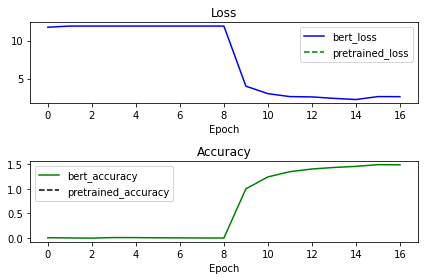

In [35]:
plt.subplot(2, 1, 1)
plt.plot(loss, 'b-', label='bert_loss')
plt.plot(loss2, 'g--', label='pretrained_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(acc, 'g-', label='bert_accuracy')
plt.plot(acc2, 'k--', label='pretrained_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

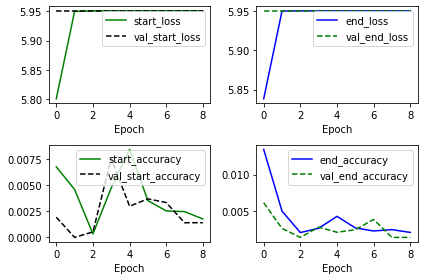

In [32]:
# BERT - training result
#plt.figure(figsize=(16, 4))

plt.subplot(2, 2, 1)
plt.plot(start_loss_list, 'g-', label='start_loss')
plt.plot(val_start_loss_list, 'k--', label='val_start_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(end_loss_list, 'b-', label='end_loss')
plt.plot(val_end_loss_list, 'g--', label='val_end_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(start_acc_list, 'g-', label='start_accuracy')
plt.plot(val_start_acc_list, 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(end_acc_list, 'b-', label='end_accuracy')
plt.plot(val_end_acc_list, 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

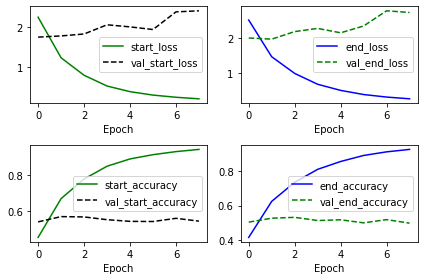

In [33]:
# BERT_pretrained - training result
#plt.figure(figsize=(16, 4))

plt.subplot(2, 2, 1)
plt.plot(start_loss_list2, 'g-', label='start_loss')
plt.plot(val_start_loss_list2, 'k--', label='val_start_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(end_loss_list2, 'b-', label='end_loss')
plt.plot(val_end_loss_list2, 'g--', label='val_end_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(start_acc_list2, 'g-', label='start_accuracy')
plt.plot(val_start_acc_list2, 'k--', label='val_start_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(end_acc_list2, 'b-', label='end_accuracy')
plt.plot(val_end_acc_list2, 'g--', label='val_end_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# 회고

1. BERT pretrained model을 활용한 KorQuAD 모델이 정상적으로 학습이 진행되었다.
    - KorQuAD 모델의 start,end accuracy는 안정적으로 증가하지만 validation start,end accuracy는 비슷한 것을 볼 수 있다.    
    - loss , accuracy 계산하여 나오는 부분을 더 공부해야 할 것이다.  
    
    
2. KorQuAD Inference 결과가 원래의 정답과 비교하여 유사하게 나오는 것을 확인하였다.
    - 평가셋에 대해 모델 추론 결과와 실제 정답의 유사성이 확인되었다.    
    - pretrained model은 정답과 예측이 동일한 것을 볼 수 있지만,    
      그냥 BERT model은 정답이 포함된 문장 전체를 예측한 것을 볼 수 있다. 
    
    
3. pretrained model 활용이 효과적임을 실험을 통해 확인하였다.
    - pretrained model을 사용하지 않았을 때 대비 학습경과의 차이를 시각화를 통해 확인하였다.
    - pretrained model을 사용했을 때 loss, accuracy가 더 좋은 것을 볼 수 있다. 